In [1]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import nltk
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.datasets import load_iris, load_boston, make_regression, make_blobs
from sklearn.ensemble import RandomForestClassifier

## Load and Manipulate the Data

In [54]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./zcta-history/2020-04-07.csv', dtype = 'str')

In [55]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [56]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [57]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)

In [58]:
data.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,median_house_income,housing_units,pop_total,med_age,pop_perc_white,pop_perc_black,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,170.0,364.0,46.70,86801.0,13305.0,23537.0,35.6,0.602456,0.121893,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,405.0,792.0,51.14,33726.0,35691.0,80736.0,40.8,0.295605,0.086108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,230.0,543.0,42.36,98151.0,31575.0,57112.0,32.1,0.776352,0.043599,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,20.0,45.0,44.44,119691.0,2082.0,3221.0,33.1,0.705992,0.007141,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,32.0,103.0,31.07,124194.0,5254.0,8131.0,29.4,0.753413,0.029517,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0


In [59]:
#Null values
data.isnull().sum(axis = 0).sort_values().tail(10)

med_monthlyhousingcost               3
med_numberrooms                      6
med_yearbuilt                        7
perc_hadbaby_pastyear_married        7
perc_hadbaby_pastyear_unmarried      7
med_value                           26
avg_hoursworked                     33
med_contractrent                    58
avg_income_deficit_pastyear        129
med_age_marriage                   177
dtype: int64

In [60]:
data[data.med_monthlyhousingcost.isnull()]

,MODZCTA,Positive,Total,zcta_cum.perc_pos,median_house_income,housing_units,pop_total,med_age,pop_perc_white,pop_perc_black,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
2,10002,405.0,792.0,51.14,33726.0,35691.0,80736.0,40.8,0.295605,0.086108,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
148,11377,736.0,1141.0,64.50,50436.0,33840.0,90615.0,36.7,0.478971,0.026673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
167,11428,241.0,355.0,67.89,67151.0,5929.0,19744.0,40.2,0.222194,0.184410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [61]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [62]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

In [63]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

perc_transport_to_work_workathome    0
perc_transport_to_work_taxi          0
perc_transport_to_work_walk          0
perc_transport_to_work_public        0
beds                                 0
dtype: int64

In [64]:
#Percent Columns
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1

In [65]:
cases_per_10k = (data.Positive / data.pop_total) * 10000

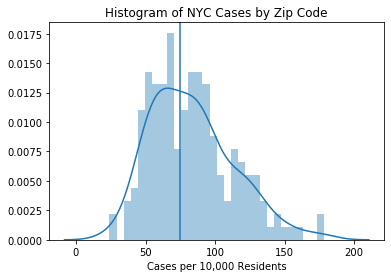

In [81]:
#Visualize the distribution of cases by zip
sns.distplot(cases_per_10k, bins = 30)
plt.title("Histogram of NYC Cases by Zip Code")
plt.xlabel("Cases per 10,000 Residents")
plt.axvline(75)
plt.show();

In [82]:
y_categorical = np.zeros(len(cases_per_10k))
y_categorical = y_categorical.astype(str)

#Low
y_categorical[cases_per_10k <= 75] = "Low"
#High
y_categorical[cases_per_10k > 75] = "High"

In [83]:
data['y_categorical'] = y_categorical

In [84]:
data['cases_per_10k'] = (data.Positive / data.pop_total) * 10000

In [85]:
data.groupby('y_categorical').size()

y_categorical
High    99
Low     78
dtype: int64

## Random Forest

In [86]:
from sklearn.model_selection import train_test_split

In [123]:
# X=data.loc[:,"median_house_income":"beds"]
X=data.drop(["MODZCTA", "Positive", "Total","zcta_cum.perc_pos","perc_leave_for_work_12ato459",
       'perc_leave_for_work_5to529', 'perc_leave_for_work_530to559',
       'perc_leave_for_work_6to629', 'perc_leave_for_work_630to659',
       'perc_leave_for_work_7to729', 'perc_leave_for_work_730to759',
       'perc_leave_for_work_8to829', 'perc_leave_for_work_830to859',
       'perc_leave_for_work_9to959', 'perc_leave_for_work_10to1059',
       'perc_leave_for_work_11to1159', 'perc_leave_for_work_12pto359',
       'perc_leave_for_work_4pto1159','y_categorical', 'cases_per_10k'], axis = 1) # Features
y=data['y_categorical']  # Labels

In [125]:
X = preprocessing.StandardScaler().fit_transform(X)

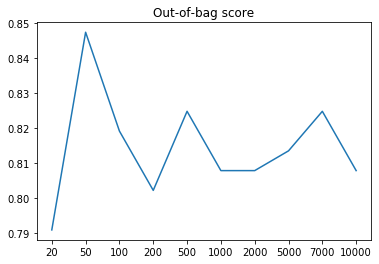

In [142]:
Bs = [20,50,100,200,500,1000, 2000, 5000, 7000, 10000]
OOBs = []
for B in Bs:
    fit_hpys = RandomForestClassifier(n_estimators=B, oob_score = True)
    fit_hpys.fit(X,y)
    OOBs.append(fit_hpys.oob_score_)

plt.plot(list(map(str,Bs)),OOBs)
plt.title("Out-of-bag score")
plt.show();


In [143]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=50, oob_score = True)

In [144]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [145]:
clf.oob_score_

0.7909604519774012

In [146]:
cols=data.drop(["MODZCTA", "Positive", "Total","zcta_cum.perc_pos","perc_leave_for_work_12ato459",
       'perc_leave_for_work_5to529', 'perc_leave_for_work_530to559',
       'perc_leave_for_work_6to629', 'perc_leave_for_work_630to659',
       'perc_leave_for_work_7to729', 'perc_leave_for_work_730to759',
       'perc_leave_for_work_8to829', 'perc_leave_for_work_830to859',
       'perc_leave_for_work_9to959', 'perc_leave_for_work_10to1059',
       'perc_leave_for_work_11to1159', 'perc_leave_for_work_12pto359',
       'perc_leave_for_work_4pto1159','y_categorical', 'cases_per_10k'], axis = 1).columns 

In [147]:
feature_imp = pd.Series(clf.feature_importances_,index=cols.tolist()).sort_values(ascending=False)
feature_imp.head(20)

perc_transport_to_work_workathome                                                           0.078126
pop_perc_hs                                                                                 0.076309
perc_transport_to_work_car                                                                  0.068911
pop_perc_some_college                                                                       0.064135
pop_perc_bachelor                                                                           0.062795
perc_transport_to_work_bike                                                                 0.036733
perc_transport_to_work_walk                                                                 0.033604
avg_number_vehicles_count                                                                   0.029307
pop_perc_masters_above                                                                      0.028282
pop_perc_asian                                                                             